# Processing script

## 1. Imports, Options and Ingestion

In [1]:
# Imports list
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score

from minisom import MiniSom

from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors
from matplotlib.colors import LinearSegmentedColormap

from matplotlib.lines import Line2D
import seaborn as sns

from matplotlib import __version__ as mplver

from sklearn.impute import KNNImputer
from sklearn.metrics import root_mean_squared_error

In [2]:
# Style is importantuntitled:Untitled-1.ipynb?jupyter-notebook
sns.set(style="white")

# Ensuring pandas always prints all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 1000)

%config InlineBackend.figure_format = 'retina'

In [3]:
# Reading the csv data
data = pd.read_csv('/home/shadybea/OneDrive/General/Data Mining/Project/DM2425_ABCDEats_DATASET.csv')

## 2. Initial Transformations

In [4]:
_rename_dict = {
        'customer_region' : 'cust_region'
        , 'payment_method' : 'pay_method'
        , 'customer_age' : 'cust_age'
        , 'vendor_count' : 'n_vendor'
        , 'product_count' : 'n_product'
        , 'n_order' : 'n_order'
        , 'is_chain' : 'n_chain'
        , 'CUI_American' : 'american'
        , 'CUI_Asian' : 'asian'
        , 'CUI_Beverages' : 'beverages'
        , 'CUI_Cafe' : 'cafe'
        , 'CUI_Chicken Dishes' : 'chicken_dishes'
        , 'CUI_Chinese' : 'chinese'
        , 'CUI_Desserts' : 'desserts'
        , 'CUI_Healthy' : 'healthy'
        , 'CUI_Indian' : 'indian'
        , 'CUI_Italian' : 'italian'
        , 'CUI_Japanese' : 'japanese'
        , 'CUI_Noodle Dishes' : 'noodle_dishes'
        , 'CUI_OTHER' : 'other'
        , 'CUI_Street Food / Snacks' : 'street_food_snacks'
        , 'CUI_Thai' : 'thai'
}

# Rename the columns for easier reference
data.rename(columns=_rename_dict, inplace=True)

In [5]:
# Make the integer value of the customer hex values, the index. 
data['customer_id'] = data['customer_id'].apply(lambda x: int(x, 16))

# Set 'customer_id' as the index
data = data[~data['customer_id'].duplicated()].set_index('customer_id')

## 2.1. Missing Values

In [6]:
# Fill missing values for first_order
data.loc[data['first_order'].isna(), 'first_order'] = 0

In [7]:
# Fill missing values for HR_0
sum_week = data[[f"DOW_{n}" for n in range(7)]].sum(axis=1)
sum_day = data[[f"HR_{n}" for n in range(24)]].sum(axis=1)

data.loc[data['HR_0'].isna(), 'HR_0'] = (sum_week - sum_day)

## 2.2. Inconsistencies

### 2.2.1. Duplicate Values

We find 94 such rows, regarding 47 entries; and simply drop the repeats.

In [8]:
data = data.drop_duplicates()

### 2.2.2. Inconsistent Values

In [9]:
# has at least one vendor
has_vendor = data['n_vendor'] != 0 

# has at least one product
has_product = data['n_product'] != 0 

# purchase must have been made on a valid dow
some_day = (data[[f"DOW_{n}" for n in range(7)]] != 0).any(axis = 1) 

# purchase must have been made at a valid hour
some_hour = (data[[f"HR_{n}" for n in range(24)]] != 0).any(axis = 1)  

# some type of cuisine must have been ordered
some_food = (data[data.columns[9:24]] != 0).any(axis = 1) 


In [10]:
data = data[(has_vendor & has_product & some_day & some_hour & some_food)]  # And we drop these values

### 2.2.3. Weird Values

In [11]:
# Customer Region
data.loc[data['cust_region'] == '-', 'cust_region'] = '8670'
data.loc[data['cust_region'].isin(['2440', '2490']), 'cust_region'] = '2400'

# Add the feature Customer CIty
data['cust_city'] = data['cust_region'].apply(lambda x: x[0])

In [12]:
# Last Promo
data.loc[data['last_promo'] == '-', 'last_promo'] = 'NO_PROMO'

## 2.3. Data Types

In [13]:
# Tidying up datatypes
for col in data.iloc[:, 0:9]:
    if col in ['last_promo', 'pay_method']:
        data[col] = data[col].astype(object)
    else:
        data[col] = data[col].astype('Int64')

for col in data.iloc[:, 9:24]:
    data[col] = data[col].astype(float)

for col in data.iloc[:, 24:]:
    data[col] = data[col].astype('Int64')

## 3. Feature Engineering

We create lists of features for easy reference.

In [14]:
# Categorical variables
non_metric_features = ['cust_region', 'last_promo', 'pay_method', 'cust_city']

# Hour of day variables
hour_features = data.columns[31:55].to_list()

# Day of week variables
day_features = data.columns[24:31].to_list()

# Cuisine features
cuisine_features = data.columns[9:24].to_list()

# Metric variables, that are not above
metric_features = data.columns.drop(non_metric_features).drop(hour_features).drop(day_features).drop(cuisine_features).to_list()

In [15]:
# Total amount spent by customer on all types of cuisine
data['total_amt'] = data[cuisine_features].sum(axis=1)

# Number of orders made by the customer
data['n_order'] = data[day_features].sum(axis=1)

# Amount spent on average per product
data['avg_amt_per_product'] = data['total_amt'] / data['n_product']

# Amount spent on average per order
data['avg_amt_per_order'] = data['total_amt'] / data['n_order']

# Amount spent on average per vendor
data['avg_amt_per_vendor'] = data['total_amt'] / data['n_vendor']

# Total days as customer
data['days_cust'] = data['last_order'] - data['first_order']

# Average days between orders
data['avg_days_to_order'] = data['days_cust'] / data['n_order']

# Days the customer is due, according to their average days between orders
data['days_due'] = 90 - data['last_order'] + data['avg_days_to_order']

# Percentage of orders placed to restaurants that are part of a chain
data['per_chain_order'] = data['n_chain'] / data['n_order']

# And we add these tese features to the metric features list.
metric_features.extend(
    [
        'n_order'
        , 'per_chain_order'
        ,'total_amt'
        , 'avg_amt_per_order'
        , 'avg_amt_per_product'
        , 'avg_amt_per_vendor'
        , 'days_cust'
        , 'avg_days_to_order'
        , 'days_due'
    ]
)

In [16]:
# Create a mask to check if each day column is populated
mask = data[[f'DOW_{i}' for i in range(7)]] > 0

# Sum over the mask to get the count of days with purchases for each row
data.loc[:, 'n_days_week'] = mask.sum(axis=1)

# Updating the list of metric features
metric_features.append('n_days_week')

In [17]:
# Create a mask to check if each hour column is populated
mask = data[hour_features] > 0

# Sum over the mask to get the count of hours with purchases for each row
data.loc[:, 'n_times_day'] = mask.sum(axis=1)

# Updating the list of metric features
metric_features.append('n_times_day')

In [18]:
# Flag customers who have purchased in more than one day
data['regular'] = (data['days_cust'] > 3)

non_metric_features.append('regular')

In [19]:
# Create a mask where values are greater than zero (indicating an order)
mask = data[cuisine_features] > 0

# # Use mask to get the ordered cuisines for each row
# data.loc[:, 'ordered_cuisines'] = mask.apply(lambda row: [cuisine for cuisine, ordered in row.items() if ordered], axis=1)

# # Updating the non_metric_features_list
# non_metric_features.append('ordered_cuisines')

# Use mask to get the number of cuisines for each row
data.loc[:, 'n_cuisines'] = mask.sum(axis=1)

# Updating the metric_features_list
metric_features.append('n_cuisines')

In [20]:
# Dropping specified columns and getting remaining columns as a list
targets = data.drop(columns=[
    'cust_age'
    , 'first_order'
    , 'last_order'
    , 'days_cust'
    , 'days_due'
    , 'avg_days_to_order'
    , 'per_chain_order'
    , 'cust_region'
    , 'cust_city'
    , 'last_promo'
    , 'pay_method'
    # , 'ordered_cuisines'
    , 'n_cuisines'
    , 'regular'
] + hour_features + day_features).columns.tolist()

# Initialize an empty DataFrame to store log-transformed columns
log_transformed = pd.DataFrame()

# Apply log1p to each column in targets and add it to log_transformed with the prefix 'log_'
for col in targets:
    log_transformed[f"log_{col}"] = np.log1p(data[col])

# We create a list of log_features to assist us in our exploration
log_features = log_transformed.columns.tolist()

# Concatenate the original DataFrame with the new log-transformed DataFrame
data = pd.concat([data, log_transformed], axis=1)

In [21]:
# Initialize dictionaries for feature groups with flags and relevant columns
feature_groups = {
    'foodie': ['n_vendor', 'n_product', 'n_order', 'n_cuisines'],
    'gluttonous': ['avg_amt_per_order', 'total_amt', 'n_chain'],
    'loyal': ['avg_amt_per_vendor'] + cuisine_features
}


# Create columns to hold the flags for each feature group
data['foodie_flag'] = 0
data['gluttonous_flag'] = 0
data['loyal_flag'] = 0

# Function to calculate IQR bounds
def calculate_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Assign flags for each feature group
for group, features in feature_groups.items():
    for feature in features:
        log_feature = f"log_{feature}"
        
        if feature == 'n_cuisines':
            log_feature = feature
        
        lower_bound, upper_bound = calculate_bounds(data.loc[(data['regular'] == 1) & (data[feature] > 0), log_feature])
        
        # Mark outliers for each group
        if group == 'foodie':
            data.loc[data['regular'] == 1, 'foodie_flag'] |= (
                data.loc[data['regular'] == 1, log_feature] > upper_bound
            ).astype(int)
        elif group == 'gluttonous':
            data.loc[data['regular'] == 1, 'gluttonous_flag'] |= (
                data.loc[data['regular'] == 1, log_feature] > upper_bound
            ).astype(int)
        elif group == 'loyal':
            data.loc[data['regular'] == 1, 'loyal_flag'] |= (
                data.loc[data['regular'] == 1, log_feature] > upper_bound
            ).astype(int)

# Display results
for group in ['foodie_flag', 'gluttonous_flag', 'loyal_flag']:
    print(f"Number of customers flagged as {group.split('_')[0]}:", data[group].sum())

non_metric_features.extend([
    'foodie_flag'
    ,'gluttonous_flag'
    ,'loyal_flag'
])

Number of customers flagged as foodie: 2709
Number of customers flagged as gluttonous: 637
Number of customers flagged as loyal: 442


In [22]:
def top_n(row, col_list, n):
    # Sort the specified columns in descending order
    sorted_row = row[col_list].sort_values(ascending=False)

    # Get the unique sorted values
    unique_sorted_values = sorted_row.unique()

    # Ensure there are enough unique values to determine the n-th largest
    if len(unique_sorted_values) >= n:
        nth_value = unique_sorted_values[n - 1]  # Get the n-th largest unique value

        # If the n-th value is 0, return None
        if nth_value == 0:
            return None
        
        # If n > 1, check for uniqueness against the (n-1)-th largest
        if n > 1:
            prev_value = unique_sorted_values[n - 2]  # (n-1)-th largest unique value
            # If nth_value is equal to the (n-1)-th value, we don't want to return it
            if nth_value == prev_value:
                return None
        
        # Return the index of the n-th largest value
        return sorted_row[sorted_row == nth_value].index[0]

    # Return None if conditions are not met
    return None

In [23]:
data['top_cuisine'] = data.apply(top_n, col_list=cuisine_features, n=1, axis=1)

non_metric_features.append('top_cuisine')

In [24]:
# Average amount spent per day as customer
data['avg_amt_per_day'] = np.round(data['total_amt'] / data['days_cust'], 4)

# Average number of products ordered per day as customer
data['avg_product_per_day'] = np.round(data['n_product'] / data['days_cust'], 4)

# Average number of orders per day as customer
data['avg_order_per_day'] = np.round(data['n_order'] / data['days_cust'], 4)

metric_features.extend([
    'avg_amt_per_day'
    ,'avg_product_per_day'
    ,'avg_order_per_day'
])

## 4. Preprocessing

Before starting the preprocessing efforts, there are some customers that can be perceived as outliers, namely the ones that were flagged as part of a group or non-regulars. Therefore, we create an auxiliary dataframe excluding these, which we will use in a fashion resembling a train-test split, where these are the training data.

In [25]:
# Create dataframe for RFM
rfm_df = data.copy(deep=True)

In [26]:
# Create dataframe with only customers which are regular and do not belong to another group
aux_df = data[data['regular'] == 1]

### 4.1. Outliers

Based on the boxplots of the EDA part of the project, we can filter our dataset using the following conditions.

In [27]:
og_rows = data.shape[0]

In [28]:
def compute_percentile_bounds(reference_data, filters):
    """
    Compute percentile bounds for the given filters using the reference dataset.

    :param reference_data: DataFrame used to compute the percentiles.
    :param filters: Dictionary of column names and (lower_percentile, upper_percentile).
    :return: Dictionary with column names and the corresponding (lower_bound, upper_bound).
    """
    bounds = {}
    
    for col, percentiles in filters.items():
        if col not in reference_data.columns:
            raise ValueError(f"Column '{col}' not found in the reference DataFrame.")

        lower_percentile, upper_percentile = percentiles
        lower_bound = reference_data[col].quantile(lower_percentile) if lower_percentile is not None else None
        upper_bound = reference_data[col].quantile(upper_percentile) if upper_percentile is not None else None
        bounds[col] = (lower_bound, upper_bound)

    return bounds

def filter_by_bounds(data, bounds):
    """
    Filter the data using precomputed bounds.

    :param data: DataFrame to be filtered.
    :param bounds: Dictionary with column names and the corresponding (lower_bound, upper_bound).
    :return: Filtered DataFrame.
    """
    conditions = []

    for col, (lower_bound, upper_bound) in bounds.items():
        if col not in data.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")

        if lower_bound is not None:
            conditions.append(data[col] >= lower_bound)
        if upper_bound is not None:
            conditions.append(data[col] <= upper_bound)

    if conditions:
        combined_condition = conditions[0]
        for condition in conditions[1:]:
            combined_condition &= condition
        return data[combined_condition]

    return data

# Example Usage:
# Compute bounds using dataset a
defined_filters = {
    **{col: (None, 0.999) for col in aux_df.columns if 'log' in col}
}
percentile_bounds = compute_percentile_bounds(aux_df, defined_filters)

# Filter dataset b using the computed bounds
data = filter_by_bounds(data, percentile_bounds)


In [29]:
print('Percentage of data kept after removing outliers:', 100 * np.round(data.shape[0] / og_rows, 4))

Percentage of data kept after removing outliers: 94.87


Let us recheck the boxplots

### 4.2. Missing Values

In [30]:
# Recreate dataframe with only customers which are regular and do not belong to another group
aux_df = data[data['regular'] == 1]

There are missing values for 'cust_age', which will be imputed using a strategy to be determined next.

In [31]:
data.loc[data['cust_age'].isna(), 'cust_age'] = aux_df['cust_age'].mean().astype('int')

In [32]:
rfm_df.loc[rfm_df['cust_age'].isna(), 'cust_age'] = aux_df['cust_age'].mean().astype('int')

#### a) Age Feature Engineering

In [33]:
# Creating age buckets
data['age_bucket'] = np.where(
    data['cust_age'] < 25, '15-24', np.where(
        data['cust_age'] < 35, '25-34', np.where(
            data['cust_age'] < 45, '35-44', np.where(
                data['cust_age'] < 55, '45-54', np.where(
                    data['cust_age'] < 65, '55-64', '65+'
                )
            )
        )
    )
)

non_metric_features.insert(4, 'age_bucket')

### 4.3. Categorical Encoding

In [34]:
# Recreate the auxiliary dataframe
aux_df = data[data['regular'] == 1]

In [35]:
ohe = OneHotEncoder(sparse_output=False).set_output(transform='pandas')
ohe_df = ohe.fit_transform(data[non_metric_features[:5]])

ohe_feat_names = ohe.get_feature_names_out()

In [36]:
data = pd.concat([data.drop(columns=non_metric_features[:5]), ohe_df], axis=1)

In [37]:
regulars = data[data['regular'] == 1].copy(deep=True)

### 4.4. Data Standardization

In [38]:
scaler = StandardScaler().set_output(transform='pandas')
regulars = pd.concat([
    scaler.fit_transform(regulars.drop(columns=list(ohe_feat_names) + non_metric_features[5:]))
    , regulars[list(ohe_feat_names) + non_metric_features[5:]]
], axis=1)

### 4.5. Multidimensional Outliers

Now, Local Outlier Factor can be applied to remove the multidimensional outliers, since the data is scaled.

In [39]:
regulars_og = regulars.shape[0]

In [40]:
lof_std = LocalOutlierFactor(n_neighbors=5)

outlier_predictions = lof_std.fit_predict(regulars.drop(columns=list(ohe_feat_names) + non_metric_features[5:]))

# Mark outliers
regulars['Outlier'] = np.where(outlier_predictions == -1, True, False)

# Remove outliers
regulars = regulars[regulars['Outlier'] == False].drop(columns=['Outlier'])

### 4.6. Feature Selection

We will perform PCA with the variables avg_amt_per_day, avg_product_per_day, avg_order_per_day, n_product and n_order - in order to reduce dimensionality and assess if the resulting principal components are of any help.

In [41]:
pca = PCA(random_state=20)
pca_feat = pca.fit_transform(regulars[['avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day', 'n_product', 'n_order']])

In [42]:
# Get the eigenvalues (explained variance)
explained_variance = pca.explained_variance_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# get the cumulative explained variance ratio 
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# Combine into a dataframe
pca_results = pd.DataFrame(
    {
        "Eigenvalue": explained_variance,
        "Difference": np.insert(np.diff(explained_variance), 0, 0),
        "Proportion": explained_variance_ratio,
        "Cumulative": cumulative_explained_variance_ratio
    },
        index=range(1, pca.n_components_ + 1)
)

pca_results

,Eigenvalue,Difference,Proportion,Cumulative
1,2.689909,0.000000,0.583384,0.583384
2,1.560448,-1.129460,0.338428,0.921812
3,0.298193,-1.262256,0.064672,0.986483
4,0.048546,-0.249647,0.010529,0.997012
5,0.013778,-0.034768,0.002988,1.000000


In [43]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=3, random_state=20)
pca_feat = pca.fit_transform(regulars[['avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day', 'n_product', 'n_order']])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]

# remember index=df_pca.index
pca_df = pd.DataFrame(pca_feat, index=regulars.index, columns=pca_feat_names)  

In [44]:
# Reassigning df to contain pca variables
df_pca = pd.concat([regulars, pca_df], axis=1)

In [45]:
loadings = df_pca[['avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day', 'n_product', 'n_order'] + pca_feat_names].corr().loc[['avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day', 'n_product', 'n_order'], pca_feat_names]

In [46]:
df_pca.drop(columns='PC2', inplace=True)

In [47]:
df_pca.rename(columns={'PC0': 'transaction_volume', 'PC1': 'interaction_rate'}, inplace=True)

In [48]:
regulars = df_pca.copy()

# End of Processing File

# RFM

In [49]:
rfm_df['recency'] = 90 - rfm_df['last_order']

In [50]:
rfm_df = rfm_df[['recency', 'n_order', 'total_amt']]

In [51]:
# rfm_df['r_rank'] = rfm_df['recency'].rank(ascending=False)
# rfm_df['f_rank'] = rfm_df['n_order'].rank(ascending=True)
# rfm_df['m_rank'] = rfm_df['total_amt'].rank(ascending=True)

In [52]:
# # Normalize the rank of customers
# rfm_df['r_rank_norm'] = (rfm_df['r_rank'] / rfm_df['r_rank'].max()) * 100
# rfm_df['f_rank_norm'] = (rfm_df['f_rank'] / rfm_df['f_rank'].max()) * 100
# rfm_df['m_rank_norm'] = (rfm_df['m_rank'] / rfm_df['m_rank'].max()) * 100

In [53]:
# rfm_df.drop(columns=['r_rank', 'f_rank', 'm_rank'], inplace=True)

In [54]:
# rfm_df['r_value'] = np.where(
#     rfm_df['r_rank_norm'] <= 33, 1, np.where(
#         rfm_df['r_rank_norm'] <= 66, 2, 3
#     )
# )

# rfm_df['f_value'] = np.where(
#     rfm_df['f_rank_norm'] <= 33, 1, np.where(
#         rfm_df['f_rank_norm'] <= 66, 2, 3
#     )
# )

# rfm_df['m_value'] = np.where(
#     rfm_df['m_rank_norm'] <= 33, 1, np.where(
#         rfm_df['m_rank_norm'] <= 66, 2, 3
#     )
# )

In [55]:
# Get the values for R, F and M
rfm_df['r_value'] = pd.qcut(rfm_df['recency'], 3, labels=[1, 2, 3])
rfm_df['f_value'] = pd.qcut(rfm_df['n_order'], 3, labels=[1, 2, 3])
rfm_df['m_value'] = pd.qcut(rfm_df['total_amt'], 3, labels=[1, 2, 3])

In [56]:
rfm_df['rfm_score'] = rfm_df['r_value'].astype('str') + rfm_df['f_value'].astype('str') + rfm_df['m_value'].astype('str')

In [57]:
# rfm_df['rfm_weighted_score'] = 0.333 * rfm_df['r_rank_norm'] + 0.333 * rfm_df['f_rank_norm'] + 0.333 * rfm_df['m_rank_norm']

In [58]:
# rfm_df['rfm_weighted_score'] *= 0.03

In [59]:
rfm_df.head()

,recency,n_order,total_amt,r_value,f_value,m_value,rfm_score
customer_id,,,,,,,
118371798366,89,2,28.88,3,1,2,312
400089128395,89,2,19.21,3,1,2,312
1060080106083,89,2,9.20,3,1,1,311
103287041752,88,2,31.56,3,1,2,312
338018592517,88,2,55.44,3,1,3,313


In [60]:
# Scaling the data
rfm_scaler = StandardScaler().set_output(transform='pandas')
rfm_scaled_ = pd.concat([
    rfm_scaler.fit_transform(rfm_df.drop(columns=['r_value', 'f_value', 'm_value', 'rfm_score']))
    ,rfm_df[['r_value', 'f_value', 'm_value', 'rfm_score']]
], axis=1)

In [61]:
rfm_features = ['recency', 'n_order', 'total_amt']

In [62]:
# Creating the dataframe with only the needed features
rfm_scaled = rfm_scaled_[rfm_features]

## R, F & M Clustering

In [63]:
# Function to calculate R² for a clustering solution
def get_rsq(df, features, label_column):
    """Calculates R² for a clustering solution.
    
    R² = SSb / SSt
    where:
    SSb = between-group sum of squares
    SSt = total sum of squares
    
    Parameters:
    df (DataFrame): The dataframe containing the features and cluster labels
    features (list): List of feature columns to consider
    label_column (str): The column containing the cluster labels
    
    Returns:
    float: R² value indicating homogeneity of the clusters
    """
    # Total Sum of Squares (SSt)
    mean = df[features].mean().values
    sst = np.sum((df[features].values - mean) ** 2)

    # Between-group Sum of Squares (SSb)
    ssb = 0
    for label in df[label_column].unique():
        group = df[df[label_column] == label]
        group_mean = group[features].mean().values
        ssb += len(group) * np.sum((group_mean - mean) ** 2)
        
    # R² Calculation
    r2 = ssb / sst if sst != 0 else 0
    return r2

In [64]:
# # Running R² Calculation for Different Hierarchical Clustering Methods
# hc_methods = ["ward", "complete", "average", "single"]
# max_nclus = 8

# # Initialize an empty list to store R² values for each method
# r2_hc = []

# # Compute R² for each clustering method and range of clusters
# for link in hc_methods:
#     print(link)
#     r2_method = []
#     for i in range(1, max_nclus + 1):  # Loop over cluster counts
#         print(i)
#         cluster = AgglomerativeClustering(n_clusters=i, metric="euclidean", linkage=link)
        
#         # Get cluster labels
#         hclabels = cluster.fit_predict(rfm_scaled)
        
#         # Concatenate the df with the cluster labels
#         df_concat = pd.concat([rfm_scaled, pd.Series(hclabels, name='labels', index=rfm_scaled.index)], axis=1)  
        
#         # Compute R² for the current number of clusters
#         r2_method.append(get_rsq(df_concat, rfm_scaled.columns.tolist(), 'labels'))
    
#     r2_hc.append(r2_method)

# # Convert R² results into a numpy array for easier manipulation
# r2_hc = np.vstack(r2_hc)

In [65]:
# # Plotting the R² values for Hierarchical Clustering Methods
# sns.set()

# # Create a figure for the plot
# fig = plt.figure(figsize=(11, 5))

# # Plot the R² values for each clustering method
# for i, link in enumerate(hc_methods):
#     sns.lineplot(data=r2_hc[i], linewidth=2.5, markers=["o"] * max_nclus, label=link)

# # Finalize the plot
# plt.legend(title="HC Methods", title_fontsize=11)
# plt.xticks(range(1, max_nclus + 1))
# plt.xlabel("Number of Clusters", fontsize=13)
# plt.ylabel("R² Metric", fontsize=13)
# fig.suptitle("$R^2$ Plot for Various Hierarchical Methods", fontsize=21)

# plt.show()

In [66]:
# # Plotting the Dendrogram for Hierarchical Clustering
# # Using the 'ward' method for dendrogram plotting (you can adjust this method)
# linkage_matrix = linkage(rfm_scaled.values, method="ward", metric="euclidean")

# sns.set()
# fig = plt.figure(figsize=(11, 5))
# # Set a threshold for cutting the dendrogram
# y_threshold = 100
# dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
# plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
# plt.title(f'Hierarchical Clustering Dendrogram: Ward Linkage', fontsize=21)
# plt.xlabel('Number of Points in Node')
# plt.ylabel(f'Euclidean Distance', fontsize=13)
# plt.show()

In [67]:
avg_silhouette = []
for nclus in range(1, 9):
    # Skip nclus == 1
    if nclus == 1:
        continue

    cluster = AgglomerativeClustering(n_clusters=nclus, metric="euclidean", linkage="ward") # Example params
    hc_labels = cluster.fit_predict(rfm_scaled)

    # Calculate centroids based on these hierarchical clusters
    centroids = []
    for i in range(nclus):
        cluster_points = rfm_scaled[hc_labels == i]  # Get points belonging to cluster i
        centroid = cluster_points.mean(axis=0)  # Calculate the mean of these points (centroid)
        centroids.append(centroid)

    centroids = np.array(centroids)

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init=centroids, n_init=1, random_state=20)
    cluster_labels = kmclust.fit_predict(rfm_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

For n_clusters = 2, the average silhouette_score is : 0.5485883187293412
For n_clusters = 3, the average silhouette_score is : 0.4534425070829796
For n_clusters = 4, the average silhouette_score is : 0.4530268723297415
For n_clusters = 5, the average silhouette_score is : 0.3593237623887525
For n_clusters = 6, the average silhouette_score is : 0.3689061526352341
For n_clusters = 7, the average silhouette_score is : 0.35746625129445037
For n_clusters = 8, the average silhouette_score is : 0.36204798636203595


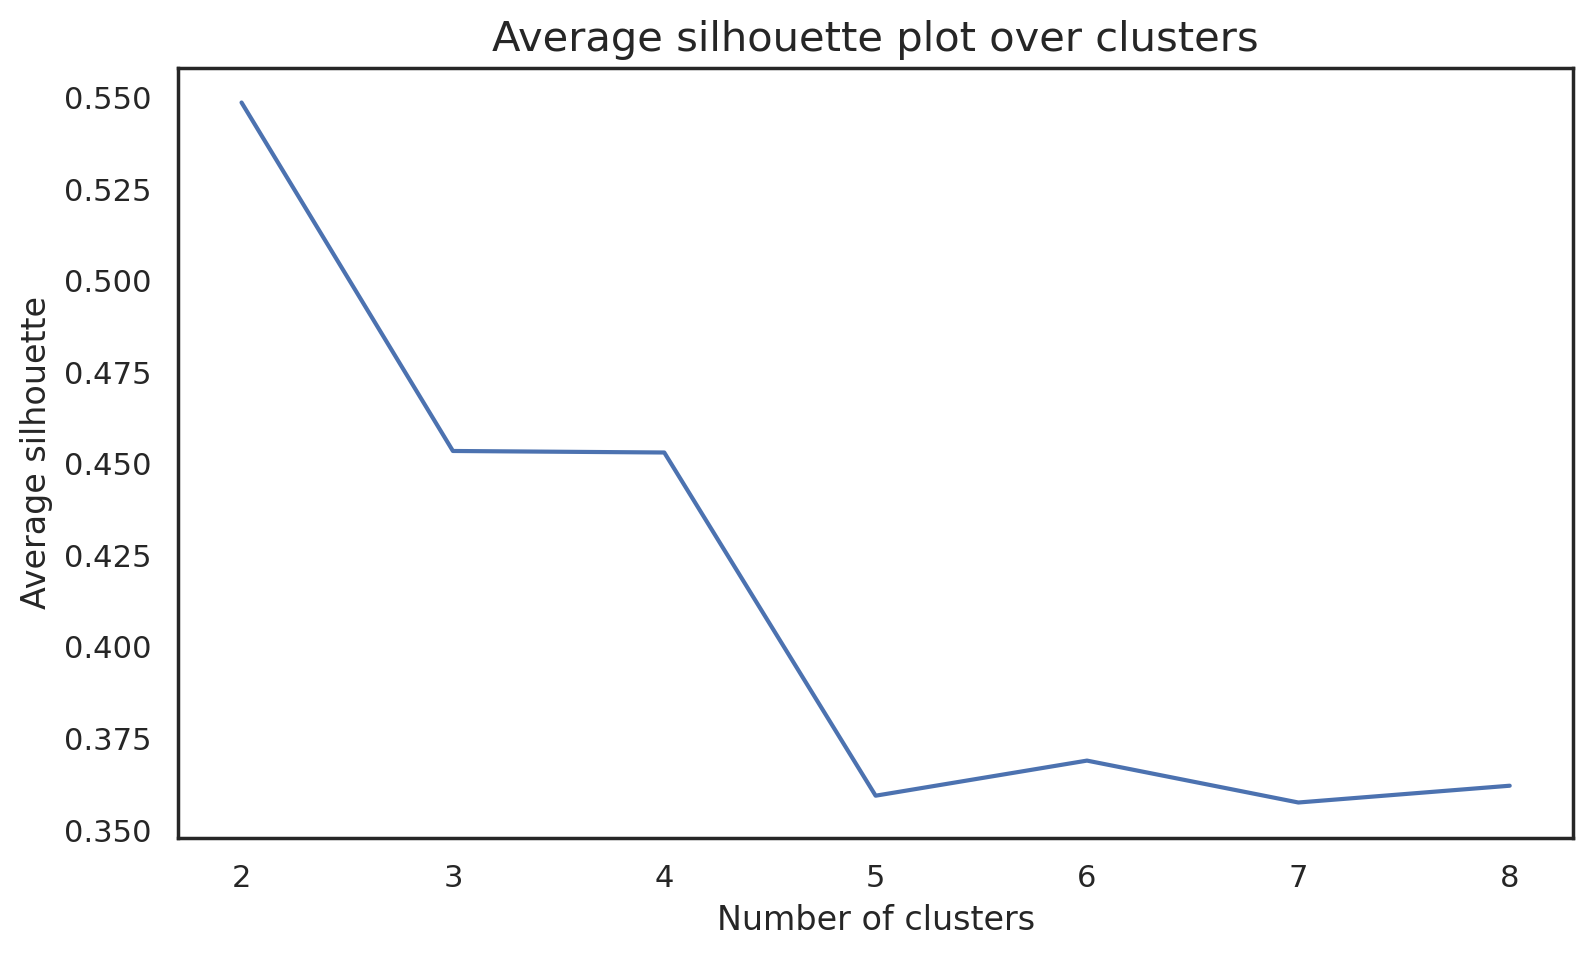

In [68]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))


#  Why range_clusters[1:] ? 
# Remember we skipped k=1 in the cell above

plt.plot(range(2, 9), ## Plot X-axis; 
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

In [69]:
n_clusters = 4

cluster = AgglomerativeClustering(n_clusters=n_clusters, metric="euclidean", linkage="ward") # Example params
hc_labels = cluster.fit_predict(rfm_scaled)

# Calculate centroids based on these hierarchical clusters
centroids = []
for i in range(nclus):
    cluster_points = rfm_scaled[hc_labels == i]  # Get points belonging to cluster i
    centroid = cluster_points.mean(axis=0)  # Calculate the mean of these points (centroid)
    centroids.append(centroid)


centroids = np.array(centroids)[:n_clusters]

In [70]:
# Hierarchical Clustreing centroids as seeds for Kmeans init
kmeans = KMeans(n_clusters=n_clusters, init=centroids, n_init=1, random_state=20)  # n_init=1 since we are providing initial centroids
kmeans.fit(rfm_scaled)

# Calculate the silhouette score to evaluate clustering
silhouette_avg = silhouette_score(rfm_scaled, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.4530268723297415


In [71]:
df_rfm_concat = pd.concat([
    rfm_scaled, 
    pd.Series(hc_labels, name='labels', index=rfm_scaled.index)
    ], 
    axis=1)
df_rfm_concat.groupby('labels').median()

,recency,n_order,total_amt
labels,,,
0,-0.484979,-0.273137,-0.314323
1,-0.873295,1.299022,1.327271
2,1.499750,-0.666177,-0.525322
3,-1.002734,4.443340,5.229676


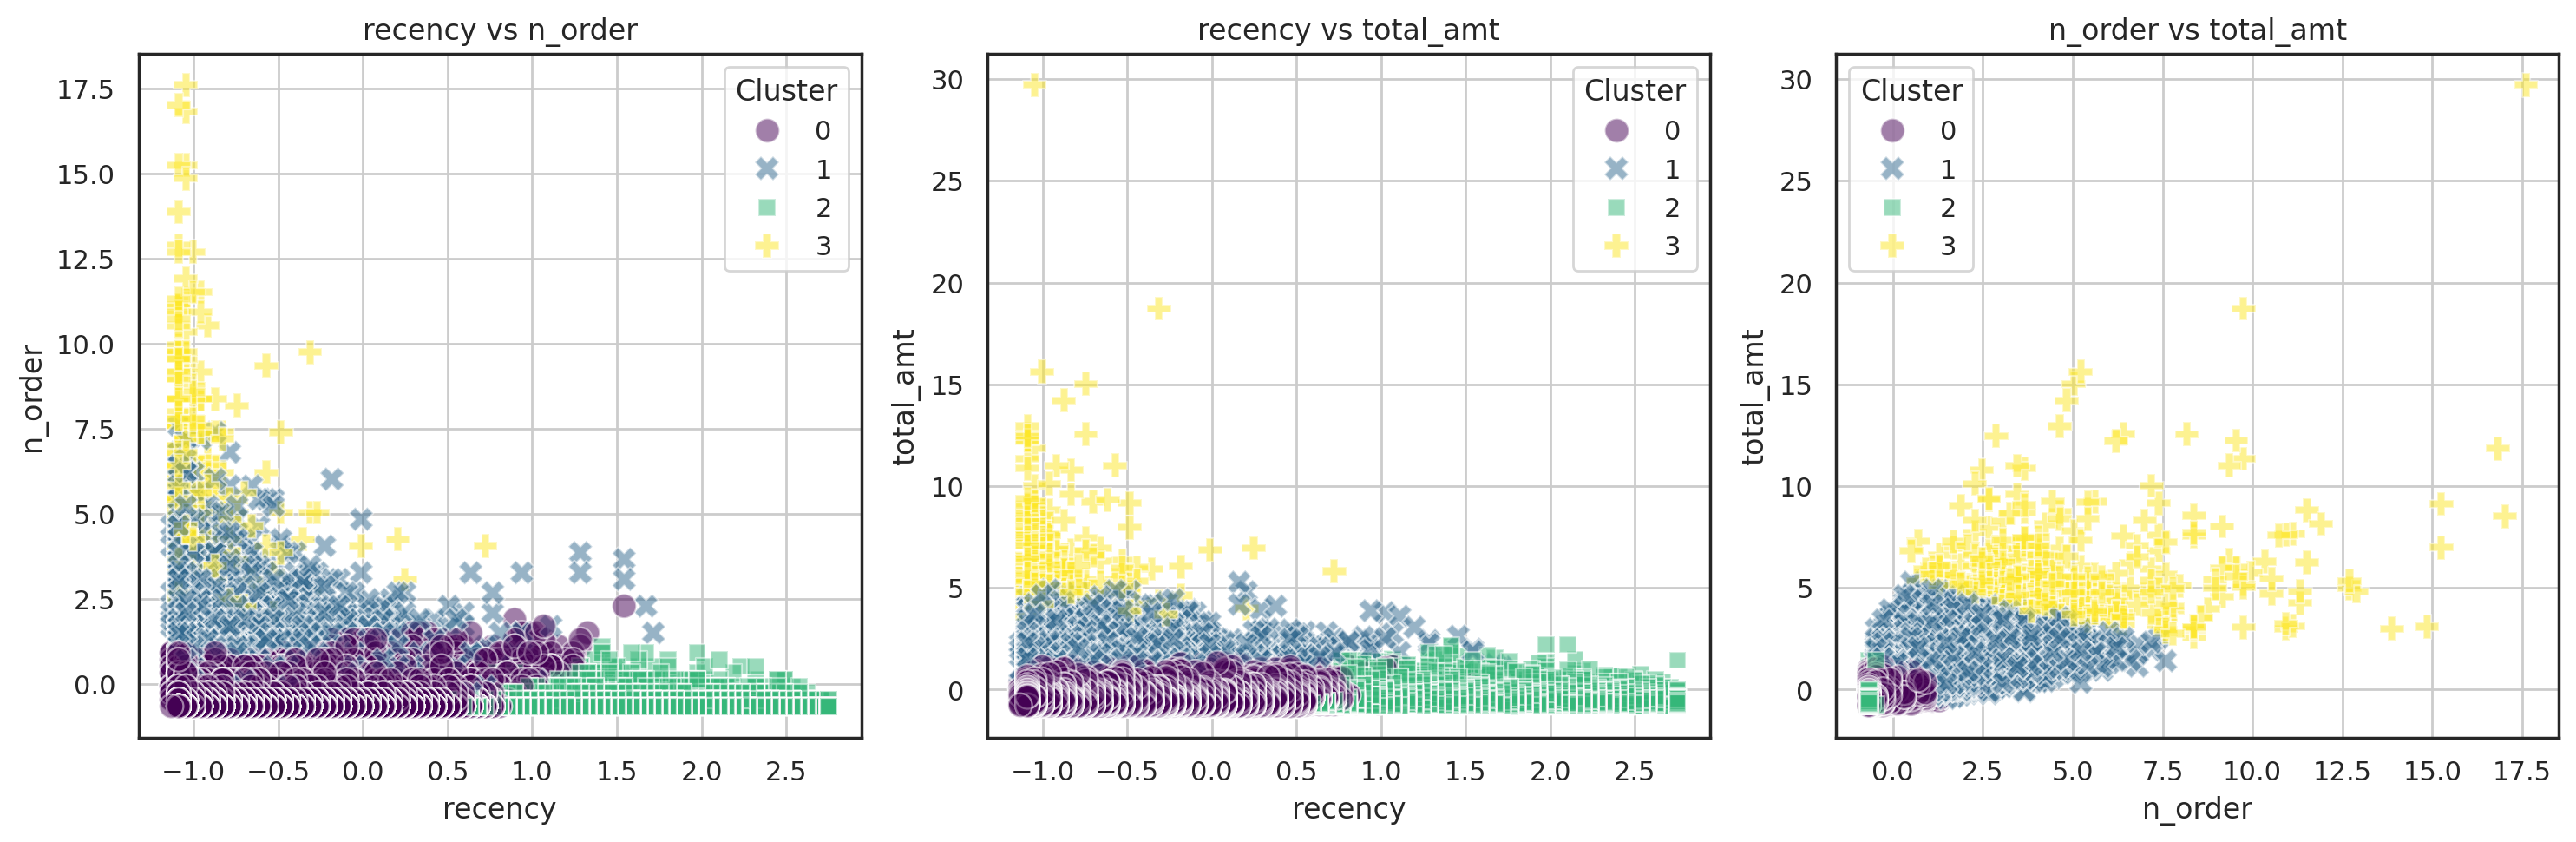

In [72]:
import itertools


combinations = list(itertools.combinations(df_rfm_concat.columns[:-1], 2))
n_combinations = len(combinations)

# Step 3: Set up subplots
n_cols = 3  # Number of columns in the grid
n_rows = (n_combinations + n_cols - 1) // n_cols  # Calculate number of rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Step 4: Plot each combination
for ax, (feature_x, feature_y) in zip(axes.flatten(), combinations):
    sns.scatterplot(
        data=df_rfm_concat,
        x=feature_x,
        y=feature_y,
        hue='labels',  # Cluster labels
        palette='viridis',
        style='labels',  # Optional: use style for labels too
        s=100,  # Point size
        alpha=0.5,  # Transparency
        ax=ax
    )
    ax.set_title(f"{feature_x} vs {feature_y}")
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)
    ax.legend(title="Cluster", loc='best')
    ax.grid(True)

# Remove any empty subplots
for i in range(n_combinations, n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

# Step 5: Adjust layout
plt.tight_layout()
plt.show()

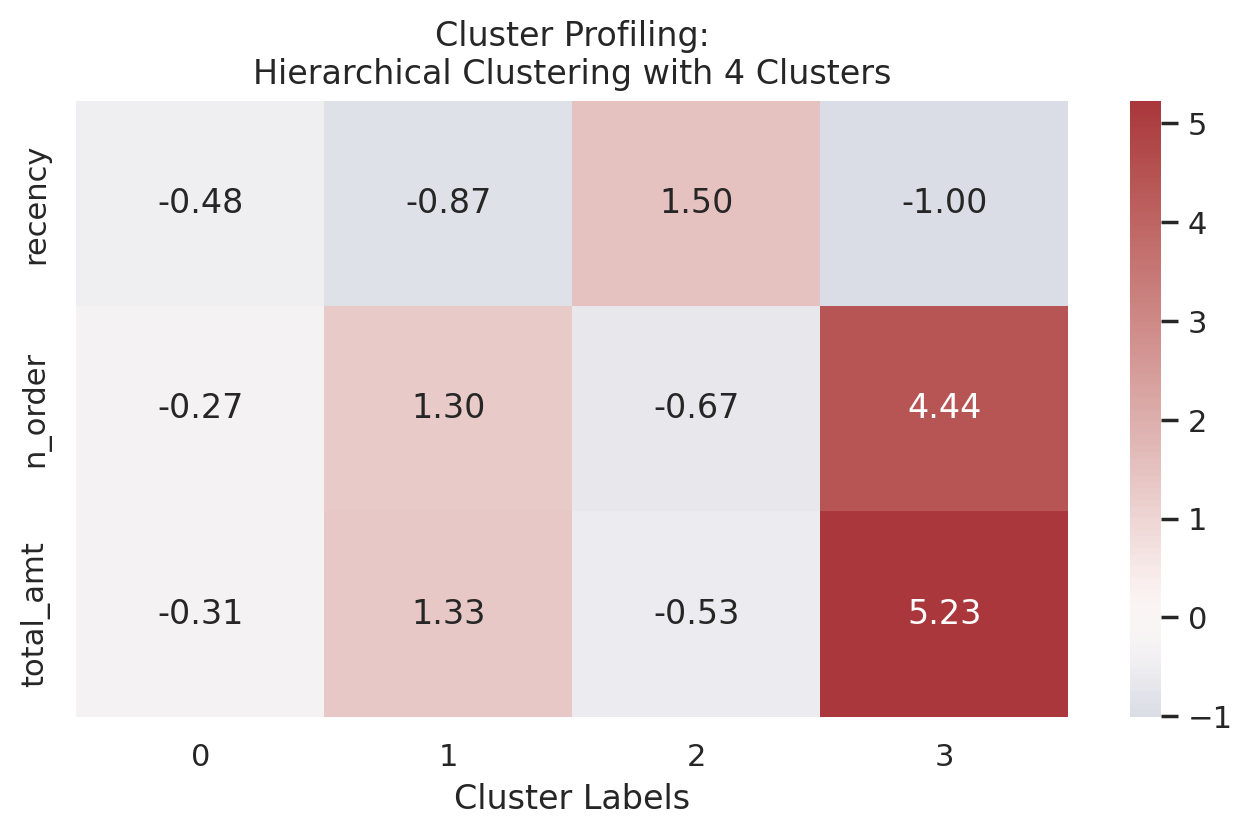

In [73]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = df_rfm_concat.groupby('labels').median().T

sns.heatmap(hc_profile,
            center=0, annot=True, cmap="vlag", fmt=".2f",
            ax=ax 
            )

ax.set_xlabel("Cluster Labels")
ax.set_title(f"Cluster Profiling:\nHierarchical Clustering with {n_clusters} Clusters")
plt.show()

### Profiling

In [74]:
rfm_profiling = pd.merge(
    df_rfm_concat
    ,regulars[
        [col for col in regulars.columns if col.startswith('last_promo_')]
        +[col for col in regulars.columns if col.startswith('pay_method_')]
        +[col for col in regulars.columns if col.startswith('cust_city_')]
        +[col for col in regulars.columns if col.startswith('cust_region_')]
        +[col for col in regulars.columns if col.startswith('age_bucket_')]
    ]
    ,left_index=True
    ,right_index=True
    ,how='left'
)

In [75]:
profiling = {
    'Promotion': [col for col in rfm_profiling.columns if col.startswith('last_promo_')]
    ,'Payment Method': [col for col in rfm_profiling.columns if col.startswith('pay_method_')]
    ,'City': [col for col in rfm_profiling.columns if col.startswith('cust_city_')]
    ,'Region': [col for col in rfm_profiling.columns if col.startswith('cust_region_')]
    ,'Age': [col for col in rfm_profiling.columns if col.startswith('age_bucket_')]
}

In [76]:
for profile, cols in profiling.items():
    cluster_profile = rfm_profiling.groupby('labels')[cols].mean().reset_index()

    # Display cluster profiling
    print(f'Cluster Profiling Based on {profile}')
    display(cluster_profile)

Cluster Profiling Based on Promotion


,labels,last_promo_DELIVERY,last_promo_DISCOUNT,last_promo_FREEBIE,last_promo_NO_PROMO
0,0,0.143284,0.129321,0.143040,0.584355
1,1,0.108275,0.110799,0.125386,0.655540
2,2,0.183575,0.141822,0.146653,0.527950
3,3,0.072727,0.118182,0.145455,0.663636


Cluster Profiling Based on Payment Method


,labels,pay_method_CARD,pay_method_CASH,pay_method_DIGI
0,0,0.704713,0.127736,0.167551
1,1,0.751753,0.111921,0.136325
2,2,0.648723,0.161146,0.190131
3,3,0.809091,0.072727,0.118182


Cluster Profiling Based on City


,labels,cust_city_2.0,cust_city_4.0,cust_city_8.0
0,0,0.349857,0.338943,0.311201
1,1,0.343899,0.308555,0.347546
2,2,0.409248,0.275362,0.315390
3,3,0.100000,0.363636,0.536364


Cluster Profiling Based on Region


,labels,cust_region_2360.0,cust_region_2400.0,cust_region_4140.0,cust_region_4660.0,cust_region_8370.0,cust_region_8550.0,cust_region_8670.0
0,0,0.286629,0.063228,0.026340,0.312603,0.012865,0.000305,0.298031
1,1,0.281907,0.061992,0.014025,0.294530,0.010379,0.000281,0.336886
2,2,0.338509,0.070738,0.025190,0.250173,0.012077,0.000000,0.303313
3,3,0.100000,0.000000,0.000000,0.363636,0.000000,0.000000,0.536364


Cluster Profiling Based on Age


,labels,age_bucket_15-24,age_bucket_25-34,age_bucket_35-44,age_bucket_45-54,age_bucket_55-64,age_bucket_65+
0,0,0.386867,0.475886,0.108103,0.023535,0.003963,0.001646
1,1,0.381206,0.479102,0.110519,0.023001,0.004488,0.001683
2,2,0.397861,0.467909,0.108696,0.020014,0.004831,0.000690
3,3,0.345455,0.490909,0.127273,0.018182,0.009091,0.009091


## Spending Diversity Clustering

In [77]:
spending_diversity = ['total_amt', 'n_cuisines', 'n_vendor', 'n_product']

In [78]:
# Creating the dataframe with the needed features
spending_diversity_df = regulars[spending_diversity]

In [79]:
n_clusters = 6

# Get the labels from hierarchical chosen clustering solution
cluster = AgglomerativeClustering(n_clusters=n_clusters, metric="euclidean", linkage="ward")
hc_labels = cluster.fit_predict(spending_diversity_df)

# Calculate centroids based on these hierarchical clusters
centroids = []
for i in range(n_clusters):
    cluster_points = spending_diversity_df[hc_labels == i]  # Get points belonging to cluster i
    centroid = cluster_points.mean(axis=0)  # Calculate the mean of these points (centroid)
    centroids.append(centroid)

centroids = np.array(centroids)

In [80]:
# Hierarchical Clustreing centroids as seeds for Kmeans init
kmeans = KMeans(n_clusters=n_clusters, init=centroids, n_init=1, random_state=20)  # n_init=1 since we are providing initial centroids
kmeans.fit(spending_diversity_df)

# Calculate the silhouette score to evaluate clustering
silhouette_avg = silhouette_score(spending_diversity_df, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.33915439788323737


In [81]:
df_sd_concat = pd.concat([
    spending_diversity_df, 
    pd.Series(hc_labels, name='labels', index=spending_diversity_df.index)
    ], 
    axis=1)

In [82]:
df_sd_concat.groupby('labels').median()

,total_amt,n_cuisines,n_vendor,n_product
labels,,,,
0,-0.228501,0.233345,-0.261198,-0.103614
1,1.202784,0.233345,0.494460,0.746781
2,3.129162,1.599890,2.761432,3.127888
3,-0.571220,-0.449928,-0.639027,-0.613851
4,0.515619,2.283163,2.383603,1.937335
5,-0.137273,1.599890,0.872288,0.576702


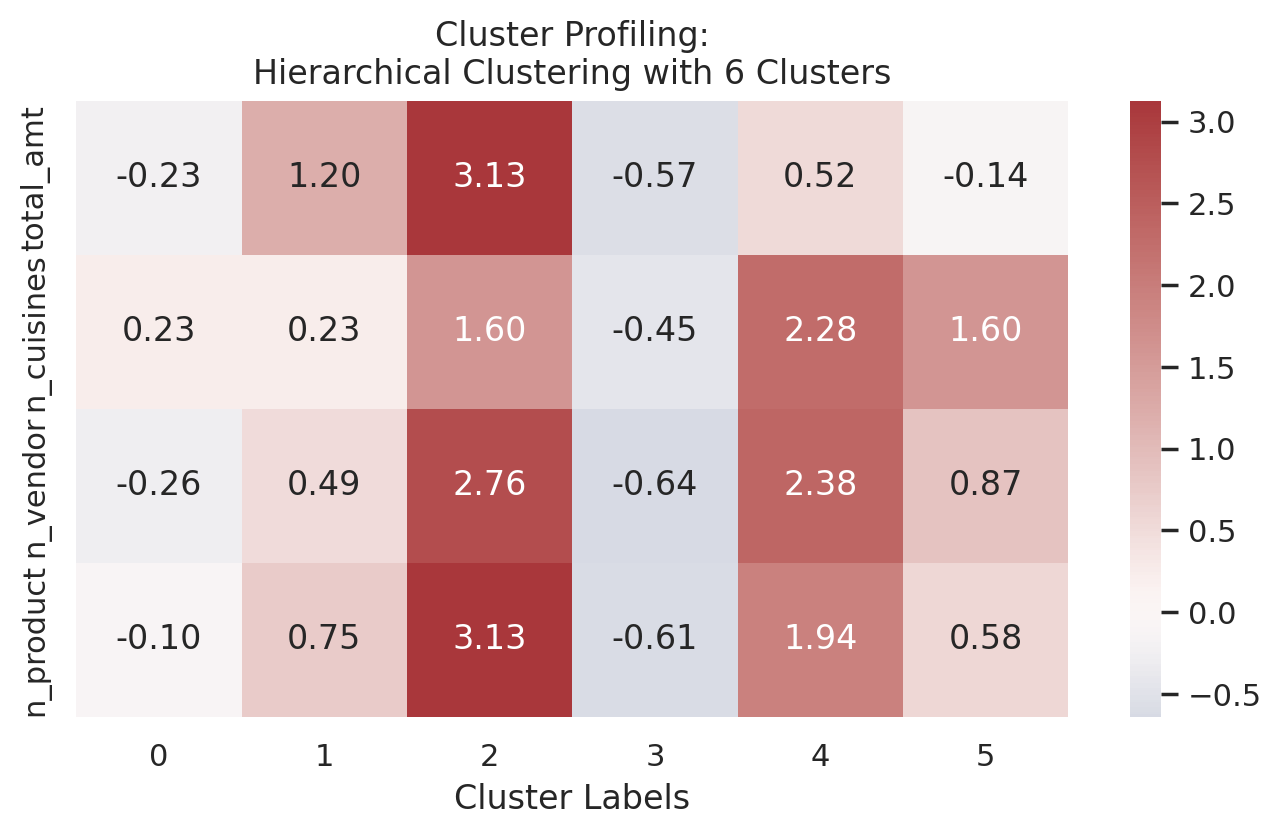

In [83]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = df_sd_concat.groupby('labels').median().T

sns.heatmap(hc_profile,
            center=0, annot=True, cmap="vlag", fmt=".2f",
            ax=ax 
            )

ax.set_xlabel("Cluster Labels")
ax.set_title(f"Cluster Profiling:\nHierarchical Clustering with {n_clusters} Clusters")
plt.show()

### Profiling

In [84]:
spending_diversity_profiling = pd.merge(
    df_sd_concat
    ,regulars[
        [col for col in regulars.columns if col.startswith('last_promo_')]
        +[col for col in regulars.columns if col.startswith('pay_method_')]
        +[col for col in regulars.columns if col.startswith('cust_city_')]
        +[col for col in regulars.columns if col.startswith('cust_region_')]
        +[col for col in regulars.columns if col.startswith('age_bucket_')]
    ]
    ,left_index=True
    ,right_index=True
    ,how='left'
)

In [85]:
profiling = {
    'Promotion': [col for col in spending_diversity_profiling.columns if col.startswith('last_promo_')]
    ,'Payment Method': [col for col in spending_diversity_profiling.columns if col.startswith('pay_method_')]
    ,'City': [col for col in spending_diversity_profiling.columns if col.startswith('cust_city_')]
    ,'Region': [col for col in spending_diversity_profiling.columns if col.startswith('cust_region_')]
    ,'Age': [col for col in spending_diversity_profiling.columns if col.startswith('age_bucket_')]
}

In [86]:
for profile, cols in profiling.items():
    cluster_profile = spending_diversity_profiling.groupby('labels')[cols].mean().reset_index()

    # Display cluster profiling
    print(f'Cluster Profiling Based on {profile}')
    display(cluster_profile)

Cluster Profiling Based on Promotion


,labels,last_promo_DELIVERY,last_promo_DISCOUNT,last_promo_FREEBIE,last_promo_NO_PROMO
0,0,0.128743,0.120687,0.141207,0.609363
1,1,0.099960,0.090247,0.134359,0.675435
2,2,0.097199,0.120264,0.131796,0.650741
3,3,0.164753,0.137695,0.144637,0.552915
4,4,0.115065,0.130486,0.122183,0.632266
5,5,0.141243,0.155771,0.133172,0.569814


Cluster Profiling Based on Payment Method


,labels,pay_method_CARD,pay_method_CASH,pay_method_DIGI
0,0,0.715458,0.126159,0.158383
1,1,0.761230,0.104006,0.134763
2,2,0.757825,0.121911,0.120264
3,3,0.678505,0.141166,0.180329
4,4,0.750890,0.107948,0.141163
5,5,0.728814,0.105730,0.165456


Cluster Profiling Based on City


,labels,cust_city_2.0,cust_city_4.0,cust_city_8.0
0,0,0.401125,0.306430,0.292446
1,1,0.056657,0.377985,0.565358
2,2,0.237232,0.349259,0.413509
3,3,0.312951,0.360481,0.326569
4,4,0.919336,0.074733,0.005931
5,5,0.764326,0.179177,0.056497


Cluster Profiling Based on Region


,labels,cust_region_2360.0,cust_region_2400.0,cust_region_4140.0,cust_region_4660.0,cust_region_8370.0,cust_region_8550.0,cust_region_8670.0
0,0,0.327557,0.073567,0.015352,0.291078,0.009728,0.000152,0.282566
1,1,0.048563,0.008094,0.015378,0.362606,0.015783,0.000809,0.548766
2,2,0.210873,0.026359,0.004942,0.344316,0.006590,0.000000,0.406919
3,3,0.257677,0.055274,0.036404,0.324077,0.015487,0.000267,0.310814
4,4,0.743772,0.175563,0.002372,0.072361,0.000000,0.000000,0.005931
5,5,0.623890,0.140436,0.001614,0.177563,0.001614,0.000000,0.054883


Cluster Profiling Based on Age


,labels,age_bucket_15-24,age_bucket_25-34,age_bucket_35-44,age_bucket_45-54,age_bucket_55-64,age_bucket_65+
0,0,0.382733,0.477276,0.110199,0.023256,0.004712,0.001824
1,1,0.387293,0.474302,0.110886,0.022663,0.003238,0.001619
2,2,0.390445,0.482702,0.102142,0.016474,0.006590,0.001647
3,3,0.389675,0.474321,0.107432,0.023231,0.003827,0.001513
4,4,0.384342,0.470937,0.115065,0.021352,0.007117,0.001186
5,5,0.388216,0.477805,0.105730,0.024213,0.003228,0.000807


## Head to Head

In [87]:
df_final_concat = pd.concat([
    df_rfm_concat.rename(columns={'labels': 'rfm_labels'})
    ,df_sd_concat.rename(columns={'labels': 'spending_labels'})
], axis=1)

In [88]:
df_final_concat.dropna(subset=['spending_labels'], inplace=True)

In [89]:
df_final_concat.head()

,recency,n_order,total_amt,rfm_labels,total_amt,n_cuisines,n_vendor,n_product,spending_labels
customer_id,,,,,,,,,
339296060607,2.578406,-0.469657,0.129852,2,0.038278,-0.449928,-0.639027,-0.613851,3.0
580679708215,2.578406,-0.469657,-0.242626,2,-0.388272,-1.133200,-0.639027,-0.613851,3.0
948800090122,2.578406,-0.469657,-0.319921,2,-0.476787,-1.133200,-0.639027,-0.783930,3.0
1043795246015,2.578406,-0.469657,-0.615319,2,-0.815068,-1.133200,-0.639027,-0.783930,3.0
1050636798106,2.578406,-0.469657,-0.421114,2,-0.592671,-0.449928,-0.639027,-0.783930,3.0


### RFM vs Spending

In [90]:
rfm_spending_prop = pd.DataFrame(
    df_final_concat.groupby(['rfm_labels', 'spending_labels']).size()  / df_final_concat.shape[0]
).reset_index()

In [91]:
rfm_spending_prop.rename(columns={0: 'Total Proportion'}, inplace=True)

In [92]:
rfm_spending_prop['Proportion_within_rfm_labels'] = rfm_spending_prop.groupby('rfm_labels')['Total Proportion'].transform(lambda x: x / x.sum())

In [93]:
rfm_spending_prop

,rfm_labels,spending_labels,Total Proportion,Proportion_within_rfm_labels
0,0,0.0,0.247802,0.347113
1,0,1.0,0.034909,0.048899
2,0,3.0,0.387394,0.542650
3,0,4.0,0.003134,0.004390
4,0,5.0,0.040655,0.056948
5,1,0.0,0.016453,0.106031
6,1,1.0,0.070950,0.457223
7,1,2.0,0.021633,0.139411
8,1,3.0,0.000044,0.000281
9,1,4.0,0.033473,0.215708


### Spending vs RFM

In [94]:
spending_rfm_prop = pd.DataFrame(
    df_final_concat.groupby(['spending_labels', 'rfm_labels']).size() / df_final_concat.shape[0]
).reset_index()

In [95]:
spending_rfm_prop.rename(columns={0: 'Total Proportion'}, inplace=True)

In [96]:
spending_rfm_prop['Proportion_within_spending_labels'] = spending_rfm_prop.groupby('spending_labels')['Total Proportion'].transform(lambda x: x / x.sum())

In [97]:
spending_rfm_prop

,spending_labels,rfm_labels,Total Proportion,Proportion_within_spending_labels
0,0.0,0,0.247802,0.865329
1,0.0,1,0.016453,0.057456
2,0.0,2,0.022112,0.077215
3,1.0,0,0.034909,0.324565
4,1.0,1,0.070950,0.659652
5,1.0,2,0.001698,0.015783
6,2.0,1,0.021633,0.818781
7,2.0,3,0.004788,0.181219
8,3.0,0,0.387394,0.792167
9,3.0,1,0.000044,0.000089


### Removing Customers

In [98]:
customers = df_final_concat[
    (
        (df_final_concat['rfm_labels'] == 0) & (df_final_concat['spending_labels'] == 3)
    )
].index

In [99]:
len(customers)

8900

In [100]:
spending_diversity_after_df = spending_diversity_df.drop(index=customers)

In [101]:
# Rescaling the data
after_scaler = StandardScaler().set_output(transform='pandas')
spending_diversity_after_df = after_scaler.fit_transform(spending_diversity_after_df)

## New Spending Diversity Clustering

In [102]:
avg_silhouette = []
for nclus in range(3, 9):
    # Skip nclus == 1
    if nclus == 1:
        continue

    cluster = AgglomerativeClustering(n_clusters=nclus, metric="euclidean", linkage="ward") # Example params
    hc_labels = cluster.fit_predict(spending_diversity_after_df)

    # Calculate centroids based on these hierarchical clusters
    centroids = []
    for i in range(nclus):
        cluster_points = spending_diversity_after_df[hc_labels == i]  # Get points belonging to cluster i
        centroid = cluster_points.mean(axis=0)  # Calculate the mean of these points (centroid)
        centroids.append(centroid)

    centroids = np.array(centroids)

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init=centroids, n_init=1, random_state=20)
    cluster_labels = kmclust.fit_predict(spending_diversity_after_df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(spending_diversity_after_df, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

For n_clusters = 3, the average silhouette_score is : 0.37735138790429046
For n_clusters = 4, the average silhouette_score is : 0.3821671705564468
For n_clusters = 5, the average silhouette_score is : 0.3177903563961907
For n_clusters = 6, the average silhouette_score is : 0.3244887160579739
For n_clusters = 7, the average silhouette_score is : 0.3283913048338019
For n_clusters = 8, the average silhouette_score is : 0.33119847740486213


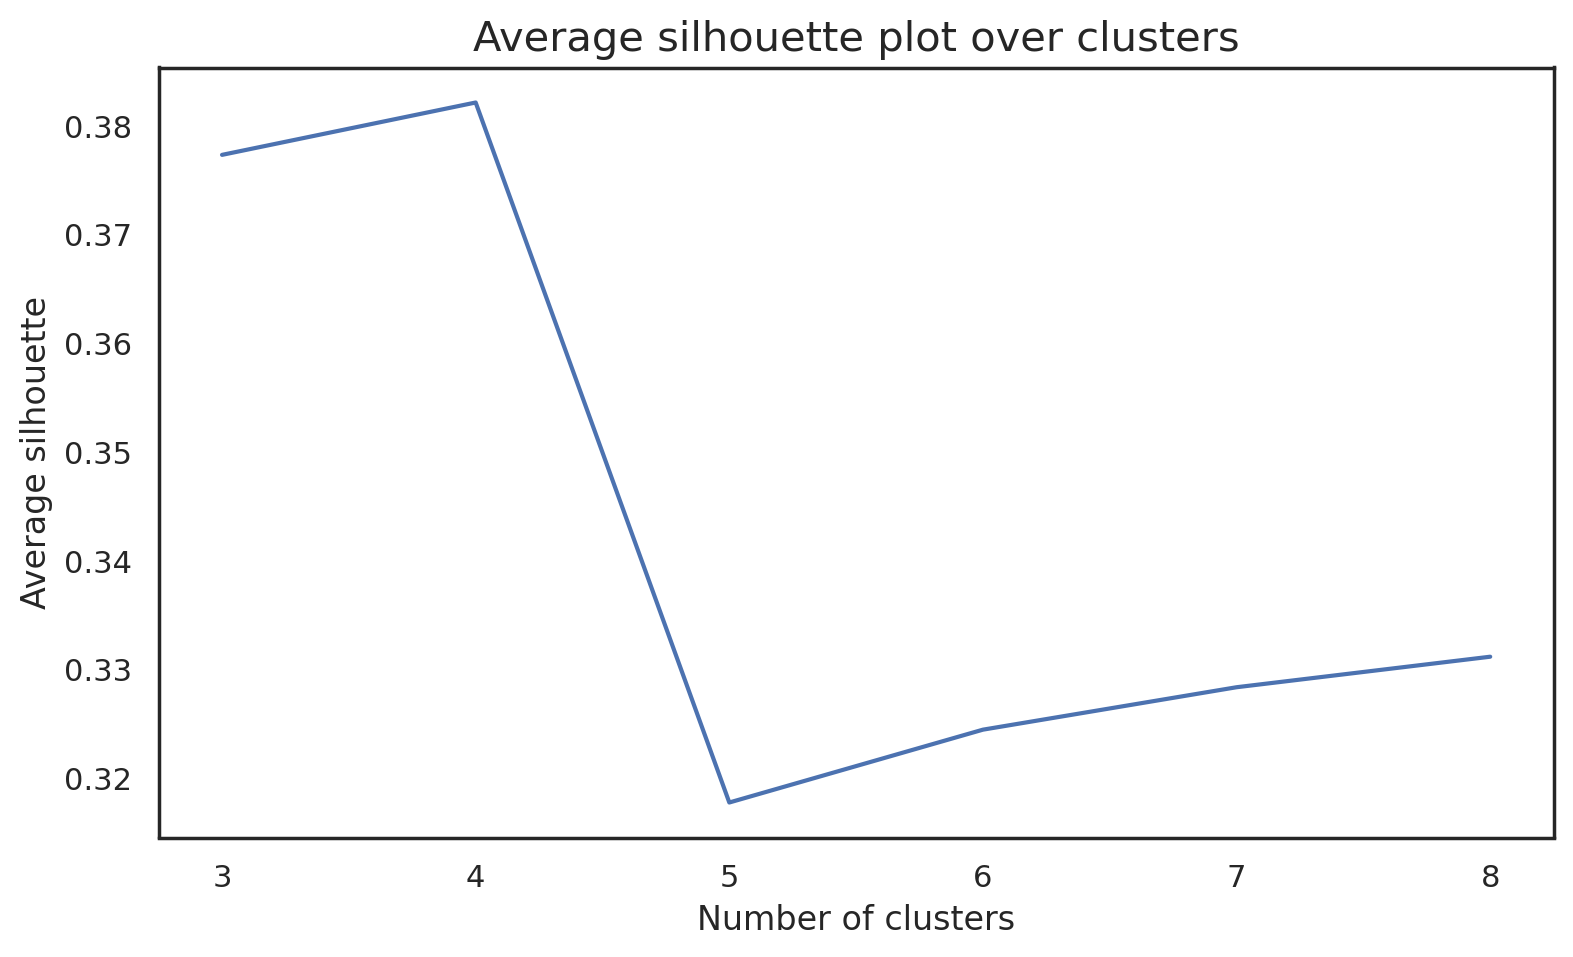

In [103]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))


#  Why range_clusters[1:] ? 
# Remember we skipped k=1 in the cell above

plt.plot(range(3, 9), ## Plot X-axis; 
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

In [104]:
n_clusters = 4

# Get the labels from hierarchical chosen clustering solution
cluster = AgglomerativeClustering(n_clusters=n_clusters, metric="euclidean", linkage="ward")
hc_labels = cluster.fit_predict(spending_diversity_after_df)

# Calculate centroids based on these hierarchical clusters
centroids = []
for i in range(n_clusters):
    cluster_points = spending_diversity_after_df[hc_labels == i]  # Get points belonging to cluster i
    centroid = cluster_points.mean(axis=0)  # Calculate the mean of these points (centroid)
    centroids.append(centroid)

centroids = np.array(centroids)

In [105]:
# Hierarchical Clustreing centroids as seeds for Kmeans init
kmeans = KMeans(n_clusters=n_clusters, init=centroids, n_init=1, random_state=20)  # n_init=1 since we are providing initial centroids
kmeans.fit(spending_diversity_after_df)

# Calculate the silhouette score to evaluate clustering
silhouette_avg = silhouette_score(spending_diversity_after_df, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.3821671705564468


In [106]:
df_concat = pd.concat([
    spending_diversity_after_df, 
    pd.Series(hc_labels, name='labels', index=spending_diversity_after_df.index)
    ], 
    axis=1)
df_concat.groupby('labels').median()

,total_amt,n_cuisines,n_vendor,n_product
labels,,,,
0,0.200163,0.480712,0.119274,0.242494
1,2.781558,1.796709,2.560712,2.891747
2,-0.524327,-0.177287,-0.578280,-0.536698
3,0.062353,1.796709,1.514381,1.177524


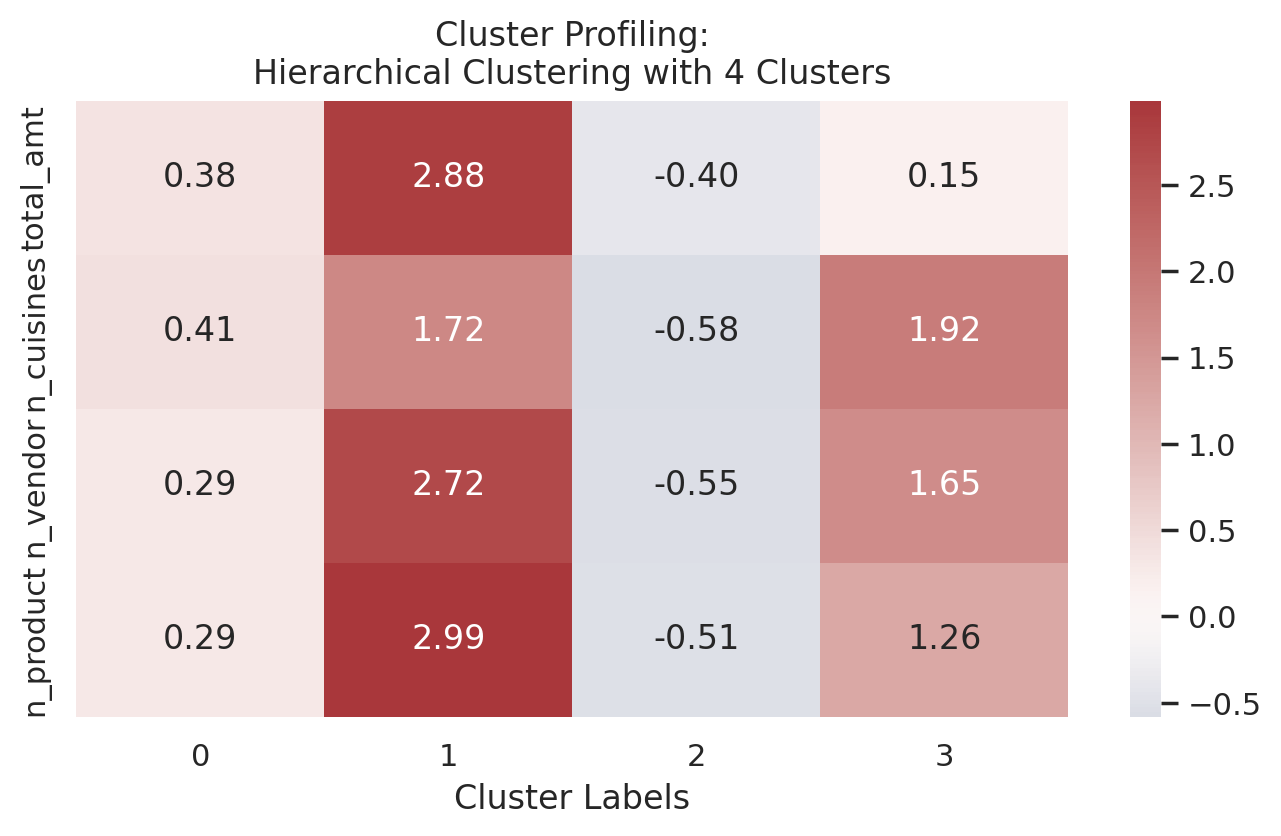

In [107]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = df_concat.groupby('labels').mean().T

sns.heatmap(hc_profile,
            center=0, annot=True, cmap="vlag", fmt=".2f",
            ax=ax 
            )

ax.set_xlabel("Cluster Labels")
ax.set_title(f"Cluster Profiling:\nHierarchical Clustering with {n_clusters} Clusters")
plt.show()

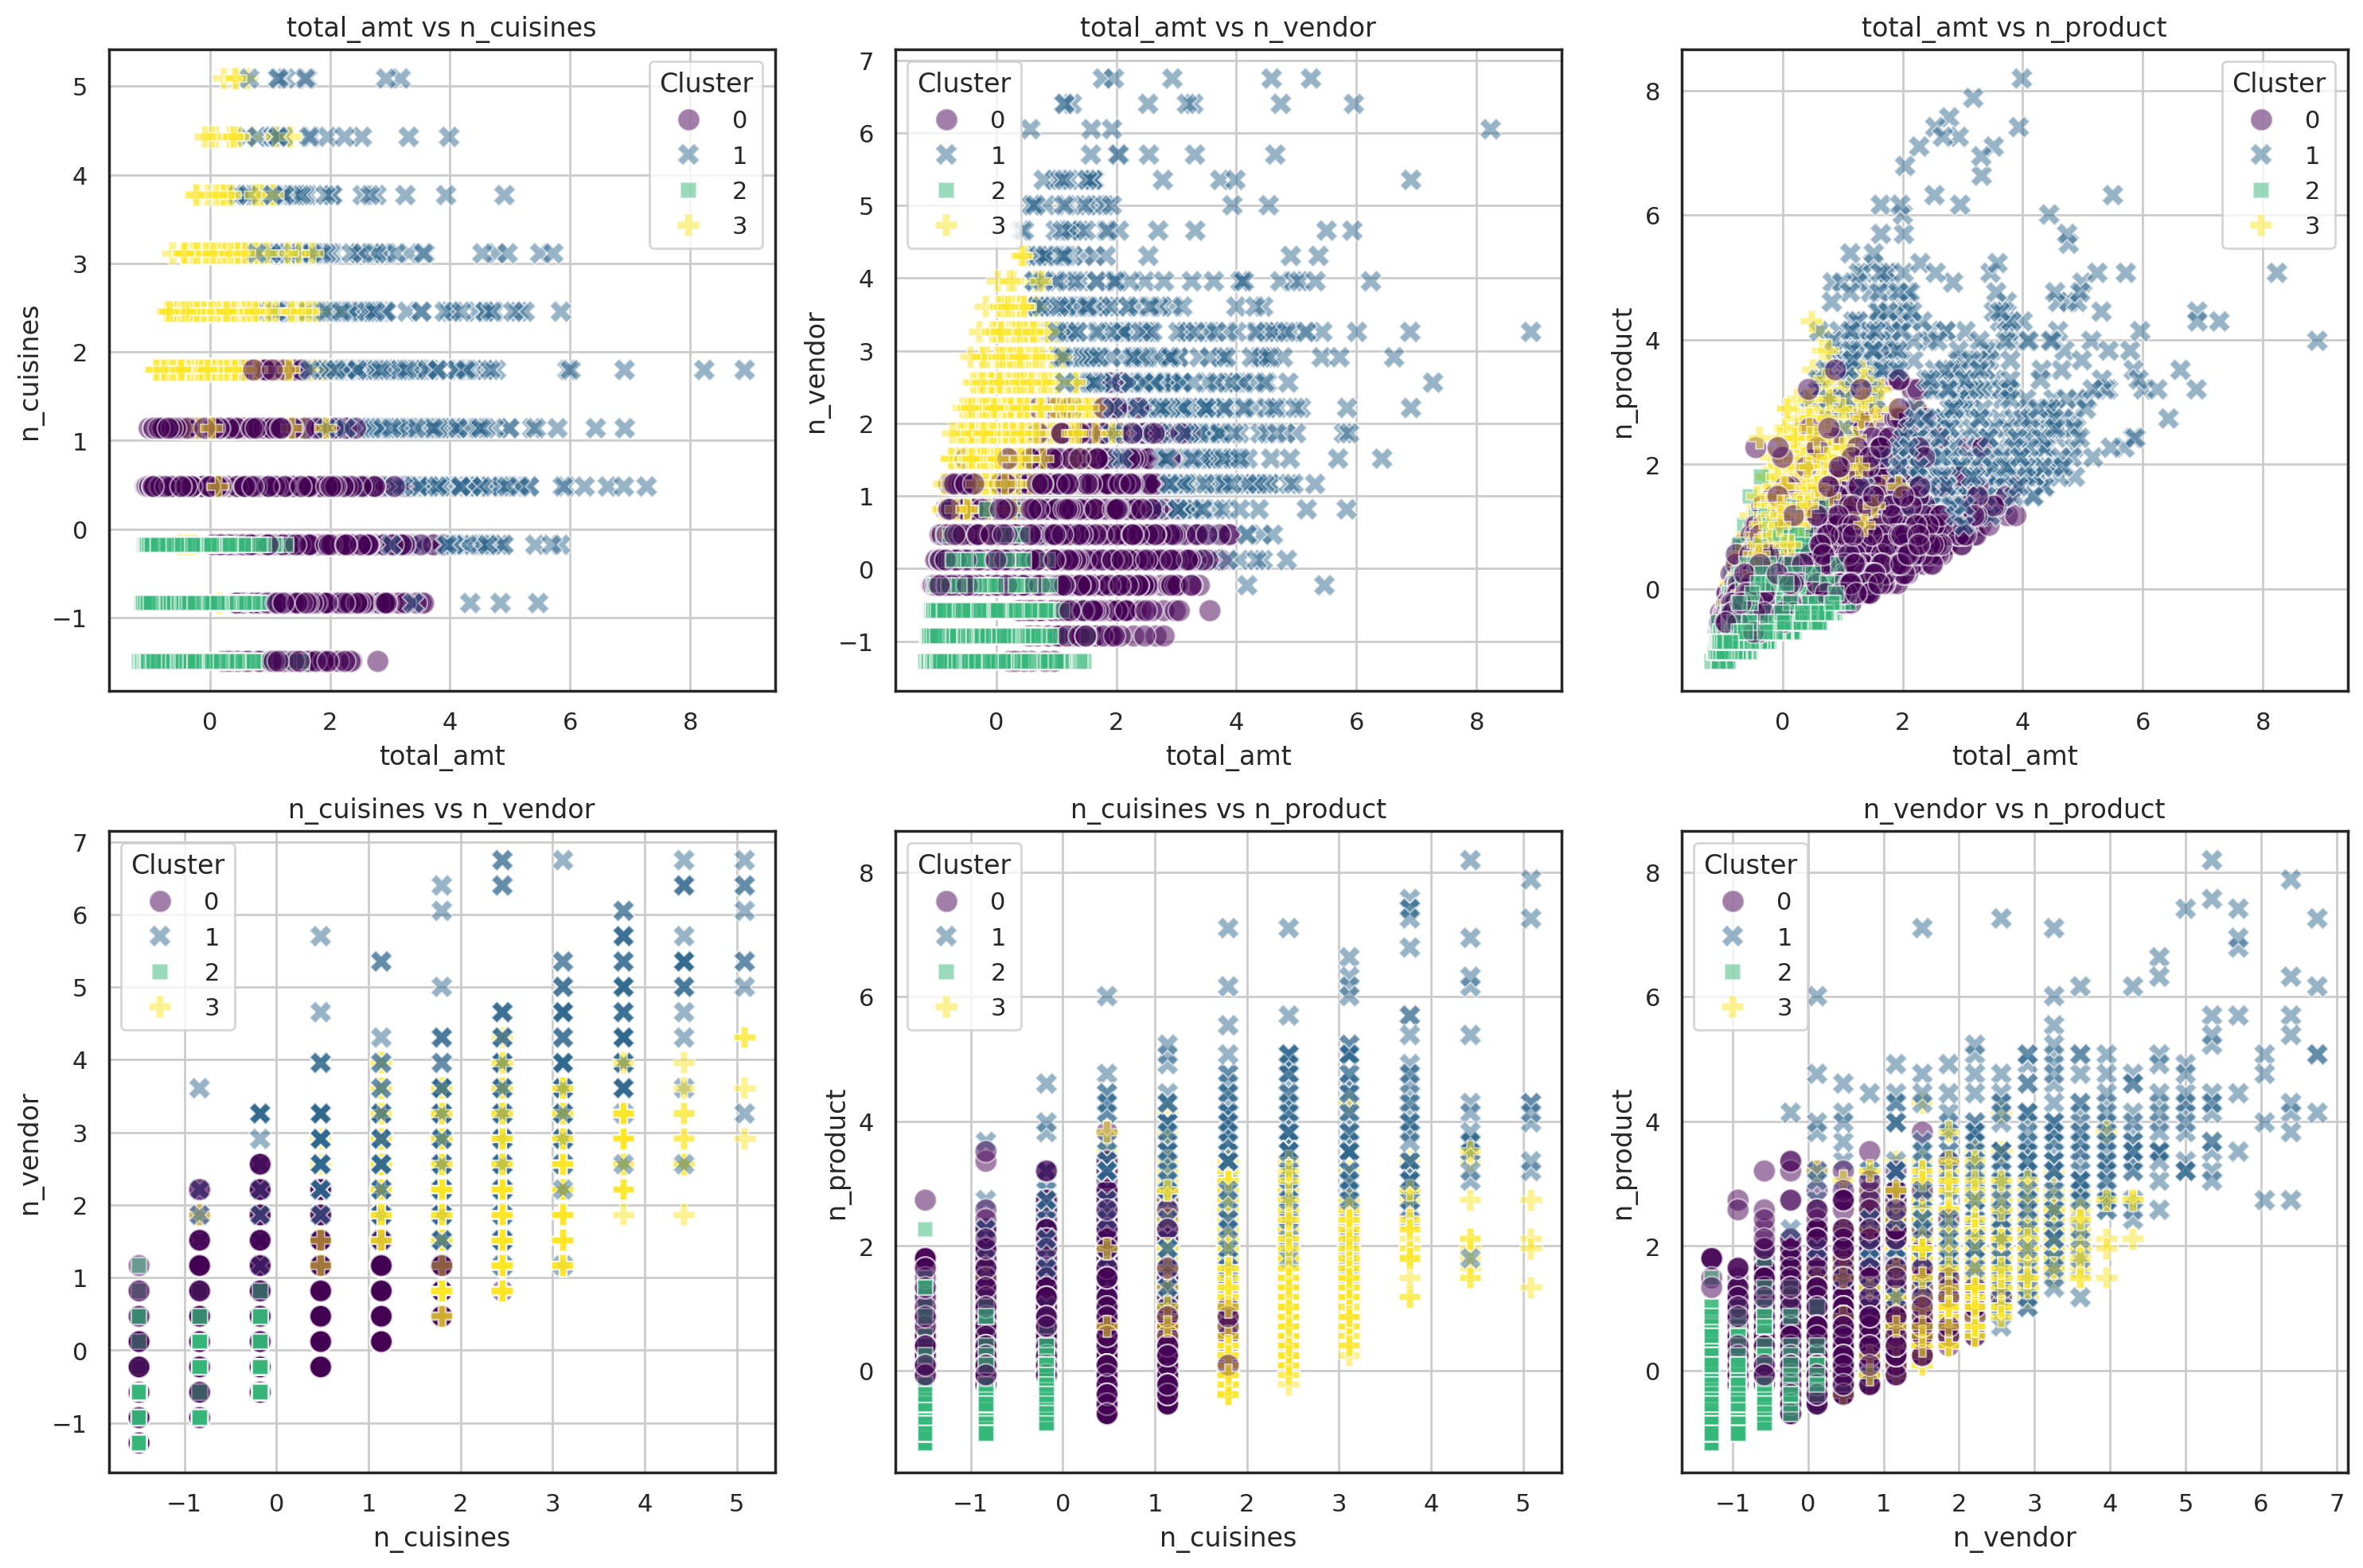

In [108]:
import itertools


combinations = list(itertools.combinations(df_concat.columns[:-1], 2))
n_combinations = len(combinations)

# Step 3: Set up subplots
n_cols = 3  # Number of columns in the grid
n_rows = (n_combinations + n_cols - 1) // n_cols  # Calculate number of rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Step 4: Plot each combination
for ax, (feature_x, feature_y) in zip(axes.flatten(), combinations):
    sns.scatterplot(
        data=df_concat,
        x=feature_x,
        y=feature_y,
        hue='labels',  # Cluster labels
        palette='viridis',
        style='labels',  # Optional: use style for labels too
        s=100,  # Point size
        alpha=0.5,  # Transparency
        ax=ax
    )
    ax.set_title(f"{feature_x} vs {feature_y}")
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)
    ax.legend(title="Cluster", loc='best')
    ax.grid(True)

# Remove any empty subplots
for i in range(n_combinations, n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

# Step 5: Adjust layout
plt.tight_layout()
plt.show()

### Profiling

In [109]:
sd_after_profiling = pd.merge(
    df_concat
    ,regulars[
        [col for col in regulars.columns if col.startswith('last_promo_')]
        +[col for col in regulars.columns if col.startswith('pay_method_')]
        +[col for col in regulars.columns if col.startswith('cust_city_')]
        +[col for col in regulars.columns if col.startswith('cust_region_')]
        +[col for col in regulars.columns if col.startswith('age_bucket_')]
    ]
    ,left_index=True
    ,right_index=True
    ,how='left'
)

In [110]:
profiling = {
    'Promotion': [col for col in sd_after_profiling.columns if col.startswith('last_promo_')]
    ,'Payment Method': [col for col in sd_after_profiling.columns if col.startswith('pay_method_')]
    ,'City': [col for col in sd_after_profiling.columns if col.startswith('cust_city_')]
    ,'Region': [col for col in sd_after_profiling.columns if col.startswith('cust_region_')]
    ,'Age': [col for col in sd_after_profiling.columns if col.startswith('age_bucket_')]
}

In [111]:
for profile, cols in profiling.items():
    cluster_profile = sd_after_profiling.groupby('labels')[cols].mean().reset_index()

    # Display cluster profiling
    print(f'Cluster Profiling Based on {profile}')
    display(cluster_profile)

Cluster Profiling Based on Promotion


,labels,last_promo_DELIVERY,last_promo_DISCOUNT,last_promo_FREEBIE,last_promo_NO_PROMO
0,0,0.116603,0.114203,0.136276,0.632917
1,1,0.096118,0.134935,0.125693,0.643253
2,2,0.145715,0.125349,0.142078,0.586859
3,3,0.115591,0.133513,0.123656,0.627240


Cluster Profiling Based on Payment Method


,labels,pay_method_CARD,pay_method_CASH,pay_method_DIGI
0,0,0.728407,0.113244,0.158349
1,1,0.763401,0.118299,0.118299
2,2,0.703479,0.133713,0.162808
3,3,0.747312,0.103047,0.149642


Cluster Profiling Based on City


,labels,cust_city_2.0,cust_city_4.0,cust_city_8.0
0,0,0.370202,0.312620,0.317179
1,1,0.279113,0.306839,0.414048
2,2,0.352649,0.311068,0.336283
3,3,0.880824,0.102151,0.017025


Cluster Profiling Based on Region


,labels,cust_region_2360.0,cust_region_2400.0,cust_region_4140.0,cust_region_4660.0,cust_region_8370.0,cust_region_8550.0,cust_region_8670.0
0,0,0.303743,0.066459,0.011516,0.301104,0.009597,0.000240,0.307342
1,1,0.251386,0.027726,0.003697,0.303142,0.003697,0.000000,0.410351
2,2,0.289490,0.063159,0.019760,0.291308,0.011759,0.000242,0.324282
3,3,0.706093,0.174731,0.002688,0.099462,0.000000,0.000000,0.017025


Cluster Profiling Based on Age


,labels,age_bucket_15-24,age_bucket_25-34,age_bucket_35-44,age_bucket_45-54,age_bucket_55-64,age_bucket_65+
0,0,0.382917,0.482246,0.105086,0.025432,0.002879,0.001440
1,1,0.399261,0.475046,0.101664,0.016636,0.005545,0.001848
2,2,0.386229,0.473633,0.111892,0.021336,0.005213,0.001697
3,3,0.384409,0.474910,0.115591,0.019713,0.005376,0.000000
